In [1]:
# Part A

# Q1 & 2 read and clean data 
import pandas as pd

# read temperature csv
temp = pd.read_csv('temp_1986.csv', header = None)

# add column header
temp.columns = ('Station_ID(int)','WBAN_ID(int)', 'Month(int)', 'Day(int)', 'Temperature_degrees_F')

# drop WBAN column
unwanted = ['WBAN_ID(int)']
temp = temp.drop(columns = unwanted)

# drop missing values
temp = temp.dropna()
temp

,Station_ID(int),Month(int),Day(int),Temperature_degrees_F
0,10010.0,1,1,17.2
1,10010.0,1,2,12.1
2,10010.0,1,3,10.4
3,10010.0,1,4,17.4
4,10010.0,1,5,26.5
...,...,...,...,...
2435445,994400.0,12,27,39.1
2435446,994400.0,12,28,37.9
2435447,994400.0,12,29,34.3
2435448,994400.0,12,30,36.9


In [2]:
# read station csv
station = pd.read_csv('stations.csv', header = None)

# add column headers
station.columns = ('Station_ID(int)','WBAN_ID(int)', 'GPS_Latitude', 'GPS_Longitude')

# drop WBAN column
station = station.drop(columns = unwanted)

# drop missing values
station = station.dropna()

# drop 0,0 GPS coordinates
station = station[station.GPS_Latitude != 0]
station = station[station.GPS_Longitude != 0]
station

,Station_ID(int),GPS_Latitude,GPS_Longitude
18,8268.0,32.950,65.567
40,10010.0,70.933,-8.667
42,10014.0,59.792,5.341
43,10015.0,61.383,5.867
44,10016.0,64.850,11.233
...,...,...,...
28116,998700.0,50.450,6.107
28117,998710.0,47.133,20.200
28121,999110.0,42.217,20.750
28122,999120.0,43.867,18.300


In [3]:
# Q3 idetify all weather stations within 100 km of Cape Canaveral (Haversine distance) 

import math 
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    #https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/
    
    # distance between latitudes and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
    
    # convert to radians 
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
  
    # apply formulae 
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2)); 
    rad = 6371
    c = 2 * math.asin(math.sqrt(a)) 
    
    return rad * c 

# location of Cape Canaveral
capelat = 28.396837
capelon = -80.605659

# drop duplicates
station = station.drop_duplicates(subset = 'Station_ID(int)')

# add haversine distance column 
station['haversine_distance'] = station.apply(lambda row: haversine(capelat,capelon,row.GPS_Latitude, row.GPS_Longitude), axis=1)

# filter stations within 100km
station_100km = station[station['haversine_distance']<=100]
station_100km


<ipython-input-3-baa63017206a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['haversine_distance'] = station.apply(lambda row: haversine(capelat,capelon,row.GPS_Latitude, row.GPS_Longitude), axis=1)


,Station_ID(int),GPS_Latitude,GPS_Longitude,haversine_distance
17652,720904.0,29.067,-81.283,99.572646
17829,722011.0,28.290,-81.437,82.221449
17875,722040.0,28.101,-80.644,33.109258
17885,722045.0,27.653,-80.243,90.045720
17887,722046.0,28.517,-80.800,23.226759
17893,722050.0,28.434,-81.325,70.471426
17894,722051.0,28.545,-81.333,72.979120
17899,722053.0,28.545,-81.333,72.979120
17905,722056.0,29.183,-81.048,97.467340
17907,722057.0,28.780,-81.244,75.496949


In [4]:
# merge two data frames on station_id (across the country)(does this look right?? should i get rid of identical ids?)
merged = temp.merge(station, on='Station_ID(int)')

In [5]:
# Q4 Estimate the temperature at Cape Canaveral on January 28, 1986 (Inverse distance weighting)
import seaborn as sns
import matplotlib.pyplot as plt

merged['inv_distance'] = 1 / merged.haversine_distance
merged['weighted'] = merged.inv_distance * merged.Temperature_degrees_F
merged['temp'] = merged.weighted / merged.inv_distance

# filter stations within 100km
merged_100km = merged[merged['haversine_distance']<=100]
# filter Jan data 
Jan_df = merged_100km[merged_100km["Month(int)"]==1]

# filter Jan 28 data
Jan28_df = Jan_df[Jan_df['Day(int)']==28]

# calculate weighted temperature on Jan28
Jan28_grouped = Jan28_df.groupby('Day(int)').sum()[['weighted','inv_distance']]
Jan28_grouped['final'] = Jan28_grouped['weighted'] / Jan28_grouped['inv_distance']
print('The temperature at Cape Canaveral on January 28, 1986 is:', Jan28_grouped.iloc[0,2], 'F')


The temperature at Cape Canaveral on January 28, 1986 is: 34.77746838276194 F


Text(0, 0.5, 'weighted temperature in F')

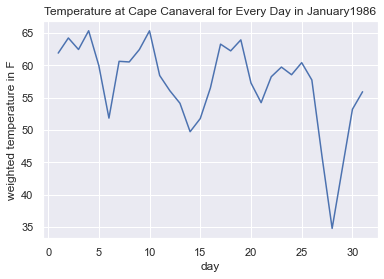

In [6]:
# Q5 Plot the temperature at Cape Canaveral for every day in January1986

# calculate weighted temperatures in Jan
Jan_grouped = Jan_df.groupby('Day(int)').sum()[['weighted','inv_distance']]
Jan_grouped['final'] = Jan_grouped['weighted'] / Jan_grouped['inv_distance']

# create another column for day as it's indexed by groupby
Jan_grouped['day'] = Jan_grouped.index

# plot
sns.set()
sns.lineplot(data = Jan_grouped, x='day', y='final')
plt.title('Temperature at Cape Canaveral for Every Day in January1986')
plt.ylabel('weighted temperature in F')

Map GPS locations to (x, y) coordinates in a2D image array. I found that mapping a latitude range of +25.0 to +50.0 and a longitude range of -125.0 to -65.0 to a 100x150 NumPy array produces pretty good results.

On an array, [0,0] is in the upper left, so that would correspond to latitude 50, longitude -125.    The point [99,149] would be the lower right and correspond to latitude 25 and longitude -65.
Part of the mapping of gps to array coordinates will involve converting to integers since, as you point out, array indices have to be integer.   (Don't round the gps coordinates, round the transformed coordinates using the int function.)

int(5.7) => 5



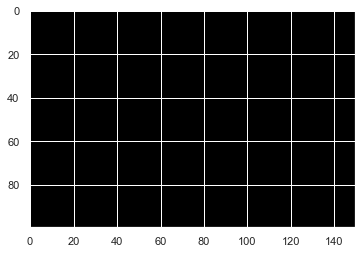

In [7]:
# Part B
# 1. Map GPS locations 
# crate empty map 
Dimension1 = 100
Dimension2 = 150
image = np.zeros((Dimension1, Dimension2,3), dtype = int)
plt.imshow(image, interpolation = 'none')

In [8]:
# 2. Map a temperature to a 3-valued RGB color array.  

# set up functions that would convert coordinates to fit in the map
def transform_lat(lat):
    '''transforms lat into a number ranged 0-100
    Args:
        lat(float): lattitude of coordinate
    
    Return:
        transformed_lat(int): a number ranged 0-100
    '''
    transformed_lat = int((lat - 25) * 4)
    
    return transformed_lat

def transform_lon(lon):
    '''transforms lon into a number ranged 0-150
    Args:
        lon(float): longitude of coordinate
    
    Return:
        transformed_lon(int): a number ranged 0-150
    '''
    transformed_lon = int(lon * 2.5 + 312.5)
    
    return transformed_lon


In [9]:
# find temperature range across the states
print(merged['temp'].min())
print(merged['temp'].max())

-9.900000000000002
99.90000000000002


In [10]:
# 2. Map a temperature to a 3-valued RGB 
def temp_to_color(temp):
    '''assigns a color to a temperature range
    Args:
        temp(floats): unweighted temperature in F across the states
        
    Return:
        color(list): a list of 3 integers representing a color. 
                     Coldest is blue, warmest is red.  
    '''
    # cold - blue
    if (temp >= -10) & (temp <= 10):
        return [0, 255, 255]
    if (temp > 10) & (temp <= 20):
        return [0, 255, 128]
    if (temp > 20) & (temp <= 30 ):
        return [0, 255, 0]
    if (temp > 30) & (temp <= 40):
        return [128, 255, 0]
    if (temp > 40) & (temp <= 50):
        return [255, 255, 0]
    if (temp > 50) & (temp <= 60):
        return [255, 178, 102]
    if (temp > 60) & (temp <= 70):
        return [255,153, 51]
    if (temp > 70) & (temp <= 90):
        return [255, 128, 0]
    if (temp > 90) & (temp <= 100):
        return [255, 0, 0]

In [11]:
# discard coordinates outside of the lat and lon range
merged = merged[(merged['GPS_Latitude'] > 25) & (merged['GPS_Latitude'] < 50)]
merged = merged[(merged['GPS_Longitude'] > -125) & (merged['GPS_Longitude'] < -65)]

# add two columns transformed lats and lons
merged['transformed_lat'] = merged.apply(lambda row: transform_lat(row.GPS_Latitude), axis = 1)
merged['transformed_lon'] = merged.apply(lambda row: transform_lon(row.GPS_Longitude), axis = 1)
merged

,Station_ID(int),Month(int),Day(int),Temperature_degrees_F,GPS_Latitude,GPS_Longitude,haversine_distance,inv_distance,weighted,temp,transformed_lat,transformed_lon
1632612,690110.0,1,6,33.8,42.608,-82.835,1592.876582,0.000628,0.021219,33.8,70,105
1632613,690110.0,1,7,18.8,42.608,-82.835,1592.876582,0.000628,0.011803,18.8,70,105
1632614,690110.0,1,8,14.9,42.608,-82.835,1592.876582,0.000628,0.009354,14.9,70,105
1632615,690110.0,1,9,9.7,42.608,-82.835,1592.876582,0.000628,0.006090,9.7,70,105
1632616,690110.0,1,13,8.6,42.608,-82.835,1592.876582,0.000628,0.005399,8.6,70,105
...,...,...,...,...,...,...,...,...,...,...,...,...
2427793,994400.0,12,27,39.1,38.900,-76.440,1229.502583,0.000813,0.031801,39.1,55,121
2427794,994400.0,12,28,37.9,38.900,-76.440,1229.502583,0.000813,0.030825,37.9,55,121
2427795,994400.0,12,29,34.3,38.900,-76.440,1229.502583,0.000813,0.027897,34.3,55,121
2427796,994400.0,12,30,36.9,38.900,-76.440,1229.502583,0.000813,0.030012,36.9,55,121


In [16]:
# 3. Plot the NumPyarray as an image plot. Repeat for both January 28th, 1986 and February 1st

# get Jan 28 and Feb 1 dataframes 
Jan28_gps_df = merged[(merged['Month(int)'] == 1) & (merged['Day(int)'] == 28)]
Feb1_gps_df = merged[(merged['Month(int)'] == 2) & (merged['Day(int)'] == 1)]


Text(0, 0.5, 'Latitude [25, 50]')

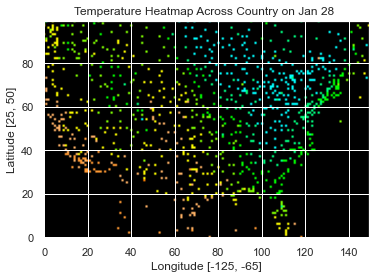

In [13]:
for index, row in Jan28_gps_df.iterrows():
    # https://www.interviewqs.com/ddi-code-snippets/iterate-rows-pandas
    transformed_lat = int(row['transformed_lat'])
    transformed_lon = int(row['transformed_lon'])
    color = temp_to_color(row['Temperature_degrees_F'])
    image[transformed_lat][transformed_lon] = color
           
        
plt.imshow(image, origin = 'lower')
plt.title('Temperature Heatmap Across Country on Jan 28 ')
plt.xlabel('Longitude [-125, -65]')
plt.ylabel('Latitude [25, 50]')

Text(0, 0.5, 'Latitude [25, 50]')

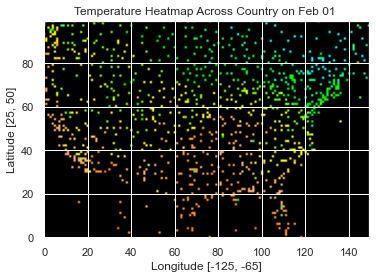

In [14]:
for index, row in Feb1_gps_df.iterrows():
    transformed_lat = int(row['transformed_lat'])
    transformed_lon = int(row['transformed_lon'])
    color = temp_to_color(row['Temperature_degrees_F'])
    image[transformed_lat][transformed_lon] = color
plt.imshow(image, origin='lower') 
plt.title('Temperature Heatmap Across Country on Feb 01 ')
plt.xlabel('Longitude [-125, -65]')
plt.ylabel('Latitude [25, 50]')